In [1]:
import os
from rich import print
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups

L.seed_everything(42)

%load_ext rich
DATA_DIR = os.path.join(os.getcwd(), "data")


c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


In [17]:
# --- HYPERPARAMETERS ---
BATCH_SIZE = 8
MAX_LENGTH = 512

LEARNING_RATE = 1e-5

N_EMBED = 768
N_HEADS = 6
N_BLOCKS = 4
DROPOUT = 0.1
NUM_LABELS = 20

device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
train = fetch_20newsgroups(data_home=DATA_DIR, subset="train")
test = fetch_20newsgroups(data_home=DATA_DIR, subset="test")


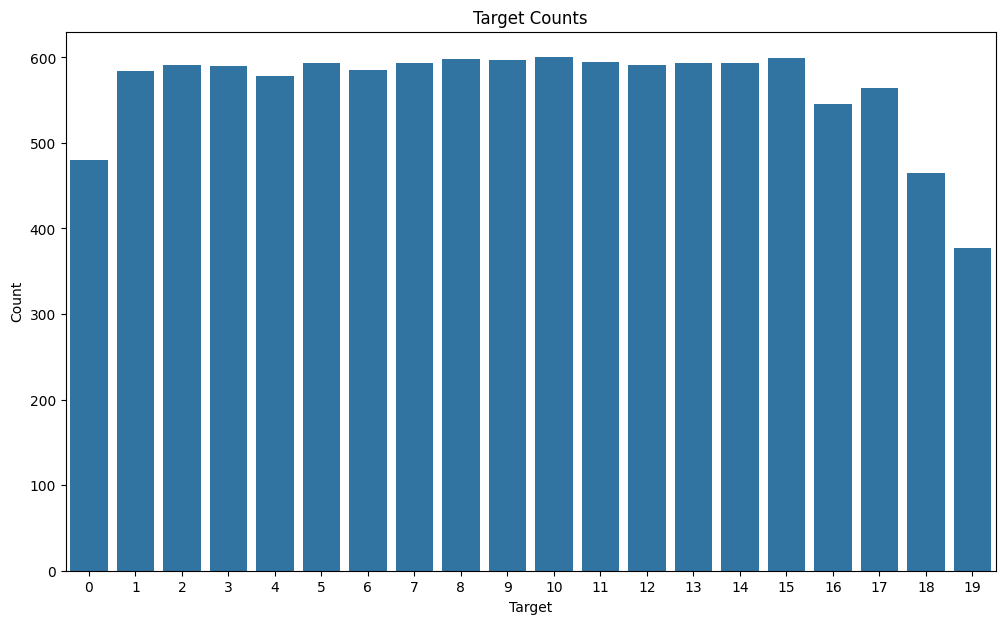

In [11]:
plt.figure(figsize=(12, 7))
sns.countplot(x=train.target)
plt.title('Target Counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [12]:
len(train.data), len(test.data)

(11314, 7532)

In [13]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


In [14]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self.texts = [text for text in data]

        self.labels = target

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return tokenizer(
            self.texts[idx],
            padding="max_length",
            max_length=MAX_LENGTH,
            truncation=True,
            return_tensors="pt",
        )

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


In [15]:
train_idx, val_idx = np.split(
    np.random.permutation(len(train.data)), [int(0.8 * len(train.data))]
)

train_dataset = TextDataset([train.data[i] for i in train_idx], train.target[train_idx])
val_dataset = TextDataset([train.data[i] for i in val_idx], train.target[val_idx])
test_dataset = TextDataset(test.data, test.target)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [16]:
len(train_loader), len(val_loader), len(test_loader)

(1132, 283, 942)

## Attention layer

In [18]:
class AttentionHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(N_EMBED, head_size, bias=False)
        self.key = nn.Linear(N_EMBED, head_size, bias=False)
        self.value = nn.Linear(N_EMBED, head_size, bias=False)

        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        weights = q @ k.transpose(-2, -1) * (C**-0.5)

        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)

        out = weights @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(N_EMBED, N_EMBED)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out


In [19]:
class FeedForward(nn.Module):
    def __init__(self, n_embed, scale_factor=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, scale_factor * n_embed),
            nn.GELU(),
            nn.Linear(scale_factor * n_embed, n_embed),  # Projection layer
            nn.Dropout(DROPOUT),
        )

    def forward(self, x):
        return self.net(x)


In [20]:
class Block(nn.Module):
    def __init__(self, n_embed, n_heads):
        super().__init__()
        self.sa_heads = MultiHeadAttention(n_heads, n_embed // n_heads)
        self.ffwd = FeedForward(n_embed, 4)

        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa_heads(self.ln1(x))  # Residual connection + attention
        x = x + self.ffwd(self.ln2(x))  # Residual connection + feed-forward
        return x

In [21]:
MultiHeadAttention(768 // 64, 64)(torch.randn(8, 512, 768)).shape

torch.Size([8, 512, 768])

In [22]:
Block(768, 6)(torch.randn(8, 512, 768)).shape

torch.Size([8, 512, 768])

## Model

In [23]:
class GPT2Classifer(nn.Module):
    def __init__(self, hidden_size, num_classes, max_seq_len, n_heads, n_layers=3):
        super().__init__()

        self.gpt2config = GPT2Config.from_pretrained("gpt2", n_layer=n_layers)
        self.gpt2 = GPT2Model.from_pretrained("gpt2", config=self.gpt2config)
        self.tf_block = Block(hidden_size, n_heads)
        self.classifier = nn.Linear(hidden_size * max_seq_len, num_classes)

    def forward(self, input_ids, attention_mask):
        gpt_out, _ = self.gpt2(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=False
        )

        gpt_out = self.tf_block(gpt_out)

        logits = self.classifier(gpt_out.view(gpt_out.size(0), -1))
        return logits

In [24]:
model = GPT2Classifer(N_EMBED, NUM_LABELS, MAX_LENGTH, N_HEADS, n_layers=4).to(device)

with torch.no_grad():
    out = model(
        train_dataset.get_batch_texts(0)["input_ids"].squeeze(1).to(device),
        train_dataset.get_batch_texts(0)["attention_mask"].to(device),
    )

    print(out.shape)


torch.Size([1, 20])

In [25]:
torch.cuda.empty_cache()

In [26]:
class TransformerClassifier(L.LightningModule):
    def __init__(
        self, hidden_size, num_classes, max_seq_len, n_heads, n_layers, lr=1e-5
    ):
        super().__init__()

        self.model = GPT2Classifer(
            hidden_size, num_classes, max_seq_len, n_heads, n_layers
        )
        self.lr = lr

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def training_step(self, batch, batch_idx):
        x, y = batch
        input_ids = x["input_ids"].squeeze(1).to(device)
        attention_mask = x["attention_mask"].to(device)
        y = y.to(device).long()

        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, y)

        acc = (logits.argmax(1) == y).float().mean()

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        input_ids = x["input_ids"].squeeze(1).to(device)
        attention_mask = x["attention_mask"].to(device)
        y = y.to(device).long()

        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, y)

        acc = (logits.argmax(1) == y).float().mean()

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        if batch_idx == 0:
            r_idx = np.random.randint(0, len(y))  # Random index

            print(
                f"Input: {tokenizer.decode(input_ids[r_idx], skip_special_tokens=True)}"
            )
            print(f"Label: {y[r_idx]}")
            print(f"Prediction: {logits.argmax(1)[r_idx]}")

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        input_ids = x["input_ids"].squeeze(1).to(device)
        attention_mask = x["attention_mask"].to(device)
        y = y.to(device).long()

        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, y)

        acc = (logits.argmax(1) == y).float().mean()

        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [27]:
model = TransformerClassifier(
    N_EMBED, NUM_LABELS, MAX_LENGTH, N_HEADS, N_BLOCKS, lr=LEARNING_RATE
).to(device)

model



TransformerClassifier(
  (model): GPT2Classifer(
    (gpt2): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-3): 4 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (tf_block): Block(
      (sa_heads): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x 

In [28]:
trainer = L.Trainer(
    accelerator="gpu",
    max_epochs=5,
    callbacks=[ModelCheckpoint(monitor="val_acc", mode="max")],
)

trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | GPT2Classifer | 82.7 M
----------------------------------------
82.7 M    Trainable params
0         Non-trainable params
82.7 M    Total params
330.747   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Input: From:  Valentin E. Vulihman <vulih@ipmce.su>
Subject: Attractive drawing on the sphere
Lines: 2
Reply-To: vulih@ipmce.su
Organization: Inst. of Prec. Mech. & Comp. Equip., Moscow, Russia

subscribe comp.graphics
quit

Label: 1

Prediction: 2

c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Input: From:  Valentin E. Vulihman <vulih@ipmce.su>
Subject: Attractive drawing on the sphere
Lines: 2
Reply-To: vulih@ipmce.su
Organization: Inst. of Prec. Mech. & Comp. Equip., Moscow, Russia

subscribe comp.graphics
quit

Label: 1

Prediction: 1

Validation: |          | 0/? [00:00<?, ?it/s]

Input: Subject: What are knots?
From: ng4@husc11.harvard.edu (Ho Leung Ng)
Nntp-Posting-Host: husc11.harvard.edu
Lines: 8

    What exactly are knots, those sore, tight spots in your muscles?
In certain kinds of massage, people try and break up these knots; it this
really helpful?


Ho Leung Ng
ng4@husc.harvard.edu

Label: 13

Prediction: 13

c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Evaluate and predict on test set

In [32]:
model = TransformerClassifier(
    N_EMBED, NUM_LABELS, MAX_LENGTH, N_HEADS, N_BLOCKS, lr=LEARNING_RATE
).to(device)

state_dict = torch.load("./lightning_logs/version_1/checkpoints/epoch=1-step=2264.ckpt")
model.load_state_dict(state_dict["state_dict"])
model


TransformerClassifier(
  (model): GPT2Classifer(
    (gpt2): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-3): 4 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (tf_block): Block(
      (sa_heads): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x 

In [33]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.7019383907318115     │
│      test_loss_epoch      │     0.994978129863739     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.994978129863739, 'test_acc_epoch': 0.7019383907318115}]